# Setup

In [ ]:
# !git clone https://github.com/Sopralapanca/medium-skill-based-agents.git
# %cd /content/medium-skill-based-agents
# !ls

In [ ]:
# !uv pip install -r pyproject.toml

Generate dataset for pretrained skills and train skill-based RL agents.

In [ ]:
# !python create_dataset.py

In [ ]:
# !python train_vos.py
# !python train_vok.py
# !python train_usr.py

Import the required packages, build the environment and test if it works

In [1]:
# general imports
import torch
import os
import numpy as np
import random


# IMPORTANT - REGISTER THE ENVIRONMENTS
import gymnasium as gym
import ale_py
gym.register_envs(ale_py)


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # ignore tensorflow warnings about CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

seed = None
if seed is not None:
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [2]:
import yaml

def load_env_config(env):
    with open(f'environment_configs/{env}.yaml', 'r') as file:
        environment_configuration = yaml.safe_load(file)["config"]
    return environment_configuration

In [3]:
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack, VecTransposeImage

def create_env(env_id, configs, seed=None):
    env = make_atari_env(env_id, n_envs=configs["n_envs"], seed=seed)
    env = VecFrameStack(env, n_stack=configs["n_stacks"])
    env = VecTransposeImage(env)
    return env

f:\VSCodeProjects\medium-skill-based-agents\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [4]:
import wandb
from dotenv import load_dotenv

load_dotenv()


key = os.getenv("WANDB_API_KEY")
if key is None:
    raise ValueError("WANDB_API_KEY not set")

def init_wandb(environment_configuration):
  wandb.login(key=key)

  tags = [
      f"fe:{environment_configuration['f_ext_name']}",
      f"game:{environment_configuration['game']}",
  ]

  run = wandb.init(
      project="medium-skill-based-agents",
      config=environment_configuration,
      sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
      monitor_gym=False,  # auto-upload the videos of agents playing the game
      group=f"{environment_configuration['game']}",
      tags=tags
      # save_code = True,  # optional
  )

  return run

Test the environment creation function

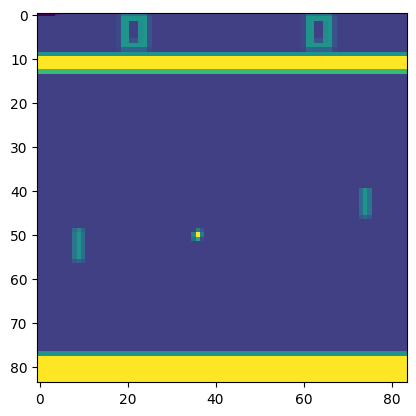

In [5]:
import matplotlib.pyplot as plt

env = "PongNoFrameskip-v4"
environment_configuration = load_env_config(env)

test_envs = create_env(env_id=env, configs=environment_configuration, seed=seed)

# execute some steps with random moves
obs = test_envs.reset()

for i in range(10):
    action = [test_envs.action_space.sample() for _ in range(environment_configuration["n_envs"])]
    obs, rewards, dones, info = test_envs.step(action)

# obs[0] has shape (4, 84, 84) because there are 4 stacked environments, take the first
observation = obs[0][-1]
plt.imshow(observation)
plt.show()

Utility function for training agents

In [6]:
from stable_baselines3.common.callbacks import EvalCallback
from wandb.integration.sb3 import WandbCallback
from utils.custom_ppo import CustomPPO  # Use custom PPO with auxiliary loss support
from rl_zoo3.utils import linear_schedule
from utils.monitor_weights import GatingMonitorCallback

def train_agent(env_id, configs, policy_kwargs, seed):
    
    run = init_wandb(configs)
    logdir = "./tensorboard_logs"
    
    monitor_dir = str(run.id)
    
    vec_envs = create_env(env_id=env_id, configs=configs, seed=seed)
    _ = vec_envs.reset()
    
    #eval_envs = create_env(env_id=env_id, configs=configs, seed=None)

    model = CustomPPO( 
        "CnnPolicy",
        vec_envs,
        learning_rate=linear_schedule(environment_configuration["learning_rate"]),
        n_steps=environment_configuration["n_steps"],
        n_epochs=environment_configuration["n_epochs"],
        batch_size=environment_configuration["batch_size"],
        clip_range=linear_schedule(environment_configuration["clip_range"]),
        normalize_advantage=environment_configuration["normalize"],
        ent_coef=environment_configuration["ent_coef"],
        vf_coef=environment_configuration["vf_coef"],
        policy_kwargs=policy_kwargs,
        verbose=0,
        device=device,
        tensorboard_log=logdir,
    )


    eval_logs = f"eval_logs/{env}/{monitor_dir}"
    os.makedirs(eval_logs, exist_ok=True)

    # eval_callback = EvalCallback(
    #     eval_envs,
    #     n_eval_episodes=100,
    #     best_model_save_path=f"./agents/{monitor_dir}",
    #     log_path=eval_logs,
    #     eval_freq=5000 * environment_configuration["n_envs"],
    #     verbose=0,
    # )
    
    
    callbacks = [
        WandbCallback(verbose=0),
        # eval_callback
    ]

    if configs["f_ext_name"] == "wsharing_attention_ext":
        # Get the feature extractor from the model
        feature_extractor = model.policy.features_extractor

        # Create monitoring callback
        gating_monitor = GatingMonitorCallback(
            feature_extractor=feature_extractor,
            env=env_id,
            save_freq=5000,  # Save every 5000 steps
            save_path=f"./{configs["f_ext_name"]}_weights",
            verbose=0,
            run_id=monitor_dir
        )
        
        callbacks.append(gating_monitor)
        
    model.learn(1000000, callback=callbacks, progress_bar=True)
    run.finish()


In [7]:
policy_kwargs = dict(
    net_arch={
        "pi": environment_configuration["net_arch_pi"],
        "vf": environment_configuration["net_arch_vf"],
    },
    # activation_fn=torch.nn.ReLU,  # use ReLU in case of multiple layers for the policy learning network
)

# Skills initialization for RL agents

In [8]:
from skills.video_object_segmentation import VideoObjectSegmentationModel
from skills.video_object_keypoints import Transporter
from skills.autoencoder import Autoencoder
from skills.unsupervised_state_representation import UnsupervisedStateRepresentationModel

# init skills
autoencoder = Autoencoder(channels=1).to(device)

environment_configuration["f_ext_kwargs"]["device"] = device 
environment_configuration["game"] = env


usr = UnsupervisedStateRepresentationModel(observation=obs[0], device=device)
vok = Transporter().to(device)
vos = VideoObjectSegmentationModel(device=device)


skills = [
    usr.get_skill(device=device),
    vok.get_skill(device=device, keynet_or_encoder="encoder"),
    vok.get_skill(device=device, keynet_or_encoder="keynet"),
    vos.get_skill(device=device)
]

# Test each skill's input adapter
print("\nTesting skill input adapters:")
test_obs = obs[:1]  # Take one sample from batch
test_obs = torch.tensor(test_obs, dtype=torch.float32).to(device)

for skill in skills:
    print(f"\nSkill: {skill.name}")
    print(f"Input shape: {test_obs.shape}")
    adapted = skill.input_adapter(test_obs)
    print(f"After adapter: {adapted.shape}")


Testing skill input adapters:

Skill: state_rep_uns
Input shape: torch.Size([1, 4, 84, 84])
After adapter: torch.Size([1, 1, 160, 210])

Skill: obj_key_enc
Input shape: torch.Size([1, 4, 84, 84])
After adapter: torch.Size([1, 1, 84, 84])

Skill: obj_key_key
Input shape: torch.Size([1, 4, 84, 84])
After adapter: torch.Size([1, 1, 84, 84])

Skill: vid_obj_seg
Input shape: torch.Size([1, 4, 84, 84])
After adapter: torch.Size([1, 2, 84, 84])


f:\VSCodeProjects\medium-skill-based-agents\.venv\Lib\site-packages\torch\functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4319.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# Pong

In [9]:
env = "PongNoFrameskip-v4"
environment_configuration = load_env_config(env)
environment_configuration["game"] = env


## Train Standard PPO Agent

In [ ]:
train_agent(env, environment_configuration, policy_kwargs, seed)

## Train WSA agent

In [ ]:
from utils.feature_extractors import WeightSharingAttentionExtractor

f_ext_kwargs = environment_configuration["f_ext_kwargs"]
environment_configuration["f_ext_name"] = "wsharing_attention_ext"
environment_configuration["f_ext_class"] = WeightSharingAttentionExtractor
f_ext_kwargs["skills"] = skills
f_ext_kwargs["features_dim"] = 256

policy_kwargs["features_extractor_class"] = environment_configuration["f_ext_class"]
policy_kwargs["features_extractor_kwargs"] = f_ext_kwargs

train_agent(env, environment_configuration, policy_kwargs, seed)


# Breakout

In [10]:
env = "BreakoutNoFrameskip-v4"
environment_configuration = load_env_config(env)
environment_configuration["game"] = env

PPO

In [11]:
train_agent(env, environment_configuration, policy_kwargs, seed)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\giaco\_netrc
wandb: Currently logged in as: james101 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Output()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
rollout/ep_len_mean,▁▂▂▂▂▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████████
rollout/ep_rew_mean,▁▁▂▂▂▄▄▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████
time/fps,███▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
train/approx_kl,▃▁▃▆██▄▄▄▆▄▄▅▅▃▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/clip_fraction,▁▃▂▄▅▄▆▅▇▆▅▄▅▆▆▇▆▇▆▆▆▆█▆▆▆▆▆▇▆▇▇▇█▆▆▇▇▆▇
train/clip_range,████▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁
train/entropy_loss,▁▁▁▂▃▆▇▇██▇▆▆▆▆▅▅▅▆▅▅▆▅▆▆▅▅▅▆▆▅▆▆▆▅▅▅▅▅▅
train/explained_variance,▁▇█▇█▇▇▆▇▆▆▆▇▆█▇▆█▇▇▆▇▇▇▇▇▇▆▆▇█▇▇▇▆▆▇▇▆▆
train/learning_rate,██████▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▂▂▂▂▂▁
+3,...


WSA

In [ ]:
f_ext_kwargs = environment_configuration["f_ext_kwargs"]
environment_configuration["f_ext_name"] = "wsharing_attention_ext"
environment_configuration["f_ext_class"] = WeightSharingAttentionExtractor
f_ext_kwargs["skills"] = skills
f_ext_kwargs["features_dim"] = 256

policy_kwargs["features_extractor_class"] = environment_configuration["f_ext_class"]
policy_kwargs["features_extractor_kwargs"] = f_ext_kwargs

train_agent(env, environment_configuration, policy_kwargs, seed)

# MsPacman

In [12]:
env = "MsPacmanNoFrameskip-v4"
environment_configuration = load_env_config(env)
environment_configuration["game"] = env

## PPO

In [13]:
train_agent(env, environment_configuration, policy_kwargs, seed)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\giaco\_netrc


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Output()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


global_step,▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
rollout/ep_len_mean,▂▁▃▆▆████▇▇▇▇▆▇▆▆▆▆▆█▇▆▆▆▆▆▆▆▆▅▅▅▅▅▆▅▅▆▆
rollout/ep_rew_mean,▁▂▂▃▃▆▆▆▇▇▇▇▇▇▇▇▆▆▆▆▇▇███▆▆▆▆▆▆▆▇▇▆▆▆▇▇▇
time/fps,▅▁▄▅▆▆▆▆▆▇▇▇▇▇██████████████████████████
train/approx_kl,▂▁▂▂▂▂▃▃▂▂▂▂▃▃▄▄▂▂▂▃█▃▆▄▇▅▄▄▄▂▅▂▁▂▁▁▂▁▁▁
train/clip_fraction,▂▁▁▄▂▂▃▃▃▄▂▃▂▂▃▄▅▅▄▅▅▇▆▄▇▄▇▇▇██▄█▇▆█▇▆▇▇
train/clip_range,███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▁▁▁
train/entropy_loss,▁▁▂▂▃▆▆▇▅▆▇▇▅▅▅▄▆▅▆▇▇▆▇▇▅█▇▆▆▆▄▆▇█▆▆▆▅█▇
train/explained_variance,▅▇▃▇▆▅█▆▃▇▁▇▇▇▆▇▆▄▅█▆█▆█▇▅▆▆█▇▇█▇▆▆▇▆▅▇▅
train/learning_rate,████▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
+3,...


## WSA

In [ ]:
f_ext_kwargs = environment_configuration["f_ext_kwargs"]
environment_configuration["f_ext_name"] = "wsharing_attention_ext"
environment_configuration["f_ext_class"] = WeightSharingAttentionExtractor
f_ext_kwargs["skills"] = skills
f_ext_kwargs["features_dim"] = 256

policy_kwargs["features_extractor_class"] = environment_configuration["f_ext_class"]
policy_kwargs["features_extractor_kwargs"] = f_ext_kwargs

train_agent(env, environment_configuration, policy_kwargs, seed)

In [ ]:
from utils.monitor_weights import plot_gating_distribution
import os

# Plot the results
weights_file = f"./gating_weights/gating_weights_{env}.pkl"
if os.path.exists(weights_file):
    plot_gating_distribution(weights_file, output_dir="./gating_plots")
else:
    raise FileNotFoundError(f"Warning: Weights file not found at {weights_file}")

# Train MOE agent

In [ ]:
# Example: Configure MoE with different exploration settings
from utils.feature_extractors import SoftHardMOE

f_ext_kwargs = environment_configuration["f_ext_kwargs"]
environment_configuration["f_ext_name"] = "moe_ext"
environment_configuration["f_ext_class"] = SoftHardMOE
f_ext_kwargs["skills"] = skills
f_ext_kwargs["features_dim"] = 256

# Exploration and load balancing parameters
f_ext_kwargs["min_temperature"] = 0.1  # Try 0.01, 0.05, 0.1, 0.2
f_ext_kwargs["temperature_decay"] = 0.99998    # Try 0.001, 0.01, 0.05


policy_kwargs["features_extractor_class"] = environment_configuration["f_ext_class"]
policy_kwargs["features_extractor_kwargs"] = f_ext_kwargs

train_agent(env, environment_configuration, policy_kwargs, seed)

In [ ]:
from utils.monitor_weights import plot_gating_distribution
import os

env = "PongNoFrameskip-v4"

# Plot the results
weights_file = f"./gating_weights/gating_weights_{env}.pkl"
if os.path.exists(weights_file):
    plot_gating_distribution(weights_file, output_dir="./gating_plots")
else:
    raise FileNotFoundError(f"Warning: Weights file not found at {weights_file}")